# The Bridges Riddle 
## (Percolation on a 2D Lattice)

In this notebook, I solve the [bridge-traversal](http://fivethirtyeight.com/features/night-falls-a-storm-rolls-in-can-you-cross-the-river/) riddle, which boils down to computing the probability of achieving bond percolation on a 2D lattice without periodic boundaries.

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
from numba import jit
from scipy.stats import binom

In [6]:
def find_root(i):
    """ Parameters
        ----------
        i (int): A valid node id of the graph
        
        Returns
        -------
        out (int): The node-id of the cluster containing node id
        
        Recursively returns the root id for the cluster for which node 
        i is a member. Redirect all pointer (ptr) values along the recursive
        path to point directly to the root node, compressing future root finding
        paths"""
    
    if ptr[i]<0:
        return i
    ptr[i] = find_root(ptr[i])
    return ptr[i]

@jit
def init_graph(n_cols):
    """ Parameters
        ----------
        n_cols (int): Number of columns in the square lattice graph
        
        Returns
        ----------
        ptr (ndarray[int,...]): Array of pointer values, one for each node
        
        Initialize the pointer values for a graph with Nx(N+1) nodes 
        (N=n_cols of the square grid). The bottom and top rows are the 
        'shores', and are thus respectively initialized connected components. 
        Otherwise, every other node is the root of its own cluster of size 1.
        
        A root node has a pointer (ptr) value of -n, where n is the size of its
        cluster.
        
        A non-root node has a pointer value given by the node-id of its cluster's
        root."""
    
    n_rows = n_cols+1
    ptr = -1*np.ones(n_cols*n_rows, dtype=int)
    N = n_cols*n_rows
    
    for i in range(0,n_cols-1): # joining the bottom row into a cluster
        ptr[i] = n_cols-1
    for i in range(N-(n_cols),n_cols*n_rows-1): # joining the top row into a cluster
        ptr[i] = n_cols*n_rows-1
    
    ptr[n_cols-1] = -1*n_cols # root node for the bottom row
    ptr[-1] = -1*n_cols # root node for the top row
    return ptr

@jit
def possible_links(n_cols):
    """ Parameters
        ----------
        n_cols (int): Number of columns in the square lattice graph
        
        Returns
        -------
        poss_link (List[Tuple(int,int),...]): A unique list of all possible
            nearest neighbor edges on the square lattice graph (without 
            periodic boundaries)"""
    poss_link = []
    cnt = 0
    end = n_cols-1
    for row in range(n_cols):
        for col in range(n_cols):
            poss_link.append((cnt,n_cols+cnt))
            if col != end and row != 0:
                poss_link.append((cnt,cnt+1))
            cnt+=1
    return poss_link

def is_percolate(links, last_ind):
    """ Parameters
        ----------
        links (List[int,...]): list of indices corresponding to the
            edges that will be added to the graph
        last ind (int): The node id for the last node in the graph
            (for this geometry: N**2+N-1, where N is the number of columns)
        
        Returns
        -------
        out (int): 1 or 0, indicating that the graph is or isn't percolated,
            respectively.
            
        Constructs the graph edge by edge, updating cluster membership via ptr
        for each iteration, and checking for graph percolation"""
    for n_link, link_id in enumerate(links):
        a,b = poss_link[link_id]
        
        r_a = find_root(a)
        r_b = find_root(b)
        if r_a != r_b:
            if ptr[r_a] <= ptr[r_b]: # cluster a is larger than b
                ptr[r_a] += ptr[r_b] # add the smaller cluster to the larger
                ptr[r_b] = r_a # point root of cluster b to a
            else:
                ptr[r_b] += ptr[r_a]
                ptr[r_a] = r_b
        
        if n_link+1 >= n_cols: # min number of edges needed to percolate
            if find_root(n_cols-1) == find_root(last_ind):
                # the first and last row of the graph share the same root (percolation occurred)
                return 1
    return 0 

# Running the Simulation

### Simulation parameters

In [121]:
n_cols = 3 # number of columns in the square grid
p_link = .5 # probability that any given bridge will stay standing
n_trial = 1000000 # number of independent simulations

# list of all possible bridges that can form between neighboring nodes [...,(node_i, node_j), ...]
poss_link = possible_links(n_cols) 
num_links = len(poss_link)

last_ind = n_cols*n_cols+n_cols-1 # The node id for the last node in the graph

### Generating the bridge configurations

The number of erect bridges for a given simulation is sampled from a binomial distribution, where the success probability $p$ is the probability that any given bridge is standing, and $n$, the number of trials, is the total number of bridges available.

Given the number of standing bridges, the ids of the bridges that are left standing are chosen randomly.

In [124]:
# For each trial, number of bridges that will be standing
n_sample_list = binom.rvs(num_links, p_link, size=n_trial) 

# For each trial, a list of the randomly chosen ids for the bridges that will be standing 
all_links = [np.random.choice(range(num_links),size=i, replace=False) for i in n_sample_list] 

### Executing the simulation

In [125]:
results = [] # list of 1s and 0s, indicating, for each trial, if the graph did or didn't percolate
for n,link in enumerate(all_links):
    ptr = init_graph(n_cols)
    results.append(is_percolate(link, last_ind))

# Plots

### Convergence of river-traversal probability (for 3x2 grid of islands)

In [126]:
dat = np.cumsum(results)/np.arange(1,len(results)+1)

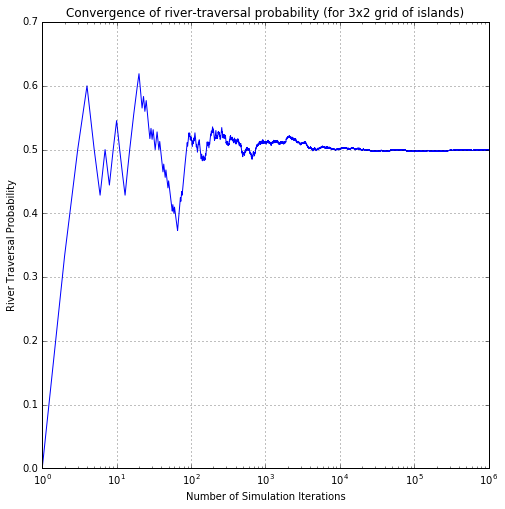

In [151]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(dat)
ax.set_xscale('log')
ax.grid()
ax.set_ylabel('River Traversal Probability')
ax.set_xlabel('Number of Simulation Iterations')
ax.set_title('Convergence of river-traversal probability (for 3x2 grid of islands)')

Given a bridge-survival probability of $p=0.5$, there is a 50% chance of crossing the river

### Results for varying lattice sizes and bridge survival probabilities

In [104]:
data5 = []
x = np.linspace(0,1,25)
for p in x:
    n_cols = 100
    p_link = p
    n_trial = 1000
    poss_link = possible_links(n_cols)
    num_links = len(poss_link)
    last_ind = n_cols*n_cols+n_cols-1

    n_sample_list = binom.rvs(num_links, p_link, size=n_trial)
    all_links = [np.random.choice(range(num_links),size=i, replace=False) 
                 for i in n_sample_list]

    results = []
    for n,link in enumerate(all_links):
        ptr = init_graph(n_cols)
        results.append(is_percolate(link, last_ind))
    data5.append(np.mean(results))

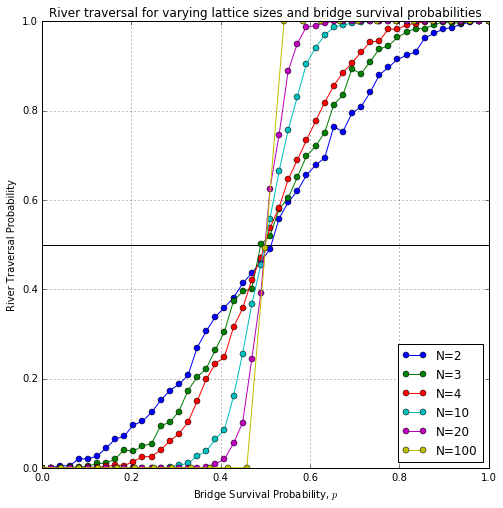

In [150]:
x2 = np.linspace(0,1,50)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(x2,data0,marker='o',label='N=2')
ax.plot(x2,data1,marker='o',label='N=3')
ax.plot(x2,data2,marker='o',label='N=4')
ax.plot(x2,data3,marker='o',label='N=10')
ax.plot(x2,data4,marker='o',label='N=20')
ax.plot(np.linspace(0,1,25),data5,marker='o',label='N=100')
ax.hlines(0.5,0,1)
ax.legend(loc='lower right')
ax.grid()
ax.set_ylabel('River Traversal Probability')
ax.set_xlabel(r'Bridge Survival Probability, $p$')
ax.set_title('River traversal for varying lattice sizes and bridge survival probabilities')

These results reveal that, for increasing lattice sizes, the system's ability to percolate is gated by a critical percolation probability, $p_{c}$. In the limit of large lattice size $N$, the system will not percolate for $p<p_{c}=0.5$, and will certainly percolate for $p_{c}=0.5<p$. The behavior of this system is pertinent in condensed matter physics, as it is a simple example of a system that exibits a critical phase transition.